# Deconvolute spatial CUT&TAG data

In [48]:
from os import makedirs, mkdir, system
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp
import torch
from sys import argv
import seaborn as sns
from skbio.stats.composition import clr, ilr
import smoother
from smoother import SpatialWeightMatrix, SpatialLoss
from smoother.models.deconv import LinearRegression, NNLS, NuSVR, DWLS, LogNormReg
from smoother.visualization import cluster_features
from matplotlib.colors import to_rgb, to_rgba

def get_color_alpha(color, alpha_arr):
    r, g, b = to_rgb(color)
    color = [(r, g, b, alpha) for alpha in alpha_arr]
    return color

def get_cost_matrix(clu1, clu2):
    n_clu1 = len(clu1.unique())
    n_clu2 = len(clu2.unique())
    cm = np.zeros((n_clu1, n_clu2))
    
    for i in range(n_clu1):
        clu_ind = (clu1 == str(i))
        for j in range(n_clu2):
            cm[i, j] = -(clu2[clu_ind] == str(j)).sum()
    return cm
        

def align_clusters(clu_list, ref_ind = None):
    n_clu_list = [len(clu.unique()) for clu in clu_list]
    if ref_ind == None:
        ref_ind = np.argmax(n_clu_list)
    
    clu_aligned_list = []
    for i, clu in enumerate(clu_list):
        if i == ref_ind:
            clu_aligned_list.append(clu)
        else:
            #n_clu = len(clu.unique())
            n_clu = len(clu_list[ref_ind].unique())
            cm = get_cost_matrix(clu, clu_list[ref_ind])
            row_ind, col_ind = sp.optimize.linear_sum_assignment(cm)
            clu_aligned_list.append(
                clu.cat.rename_categories(col_ind).astype(str)
            )
    
    return clu_aligned_list, ref_ind


def plot_col_mean(sp_score, coords):
    col_mean = [sp_score.mean(0)[coords.imagecol==col].mean() for col in coords.imagecol.unique()]
    sns.lineplot(x=range(len(col_mean)), y=col_mean)
    if sum(np.absolute(col_mean - np.mean(col_mean)) > 3*np.std(col_mean))>0:
        idx = coords.imagecol.unique()[np.absolute(col_mean - np.mean(col_mean)) > 3*np.std(col_mean)]
        print("Remove Column: {}".format(idx))
        return np.array(idx)
    else:
        return np.array([])
    
def plot_row_mean(sp_score, coords):
    row_mean = [sp_score.mean(0)[coords.imagerow==row].mean() for row in coords.imagerow.unique()]
    sns.lineplot(x=range(len(row_mean)), y=row_mean)
    if sum(np.absolute(row_mean - np.mean(row_mean)) > 3*np.std(row_mean))>0:
        idx = coords.imagerow.unique()[np.absolute(row_mean - np.mean(row_mean)) > 3*np.std(row_mean)]
        print("Remove Row: {}".format(idx)) 
        return np.array(idx)
    else:
        return np.array([])

# ## H3K4me3 - 20um

# ### Load preprocessed data

# In[3]:

# data_dir = argv[1] #"../../data/cutntag/processed/"
# assay = argv[2] #'H3K4me3'
# resolution = argv[3] #'20um'

class RunDeconv():
    def __init__(self, data_dir, out_dir, assay, resolution, num_genes):
        self.data_dir = data_dir
        self.output_dir = out_dir
        self.assay = assay
        self.resolution = resolution
        self.num_genes = num_genes
        self.coords, self.sp_score, self.ref_exp, self.ct_names = self.load_data()

        self.model_names, self.p_inf_list = self.run_deconv()
        makedirs(self.output_dir + 'plots/', exist_ok=True)
        self.card_names, self.p_card_list= self.run_card()
        self.model_all_names = self.model_names + self.card_names
        self.p_all_list = self.p_inf_list + self.p_card_list

    
    def load_data(self):

        # spatial coordinates, num_spot x 2
        coords = pd.read_csv(self.data_dir + self.assay + "." + self.resolution + ".coord.csv", header=0, index_col=0)

        # spatial gene activity scores (num_gene x num_spot)
        sp_score = pd.read_csv(self.data_dir + self.assay + "." + self.resolution + ".var_gene_score.csv", header=0, index_col=0)
        
        print(sp_score.std(1))

        # single-cell derived reference count matrix, num_gene x num_celltype
        ref_exp = pd.read_csv(self.data_dir + "ref.all_genes.bycluster.csv", header=0, index_col=0)

        ct_names = np.array(ref_exp.columns)


        # keep only shared genes
        gene_names = sp_score.index.intersection(ref_exp.index)
        sp_score = sp_score.loc[gene_names]
        ref_exp = ref_exp.loc[gene_names,ct_names]

        print(f"Number of spots: {sp_score.shape[1]}")
        print(f"Number of genes: {len(gene_names)}")
        print(f"Number of celltypes: {len(ct_names)}")


        col_to_remove = plot_col_mean(sp_score, coords)
        row_to_remove = plot_row_mean(sp_score, coords)

        # filter out abnormal spots
        keep_spots = ~(coords.imagerow.isin(row_to_remove))|(coords.imagecol.isin(col_to_remove))
        sp_score = sp_score.loc[:, keep_spots]
        coords = coords.loc[keep_spots,:]
        keep_spots.to_csv(self.data_dir + self.assay + "." + self.resolution + ".spotqc.csv", header=False)

        print(f"Number of spots after QC: {sp_score.shape[1]}")

        return coords, sp_score, ref_exp, ct_names

    def run_deconv(self):
        # convert data into torch tensor
        x = torch.tensor(self.ref_exp.values).float()
        y = torch.tensor(self.sp_score.values).float()
        # calculate spatial weight matrix
        weights = SpatialWeightMatrix()
        weights.calc_weights_knn(self.coords, k=4)
        weights.scale_by_expr(y)

        # prepare spatial loss
        spatial_loss = SpatialLoss('icar', weights, rho=0.99)


        # ### Run deconvolution

        # #### NNLS
        torch.manual_seed(20220814)

        deconv_configs = {'lr':3e-3, 'tol':1e-6, 'max_epochs':-1, 'verbose':False}
        l_sp_list = [0, 1, 3, 10]
        deconv_models = []
        model_names = [f'nnls_sp{str(l_sp)}' for l_sp in l_sp_list]

        # add NNLS models
        for l_sp in l_sp_list:
            model = NNLS()
            model.deconv(x, y, spatial_loss=spatial_loss,
                        lambda_spatial_loss=l_sp, **deconv_configs)
            deconv_models.append(model)
            
        # extract estimated celltype abundances 
        p_inf_list = [m.get_props().numpy() for m in deconv_models]

        return model_names, p_inf_list

    def run_card(self):
        # #### CARD (remember to rerun CARD with QC passed data)
        system('zsh run_CARD.sh ' + self.data_dir + ' ' + self.output_dir + ' ' + self.assay + '.' + self.resolution )

        # load card results
        res_dir = self.output_dir
        sample_id = self.assay+"."+self.resolution

        # card_sp is the model with CARD-chosen optimal phi (can be zero, aka no spatial loss)
        card_names = ["card", "card_sp"]
        p_card_list = [np.loadtxt(f"{res_dir}/{sample_id}_{name}.txt") 
                    for name in card_names]
        return card_names, p_card_list

    
    # ### Visualize results
    def plot_model_and_ct(self, model_to_plot, ct_to_plot, ct_group_name=None, ct_colors=None):
        # #### All results
        model_idx = [np.where(np.array(self.model_all_names) == m)[0][0]
                    for m in model_to_plot]

        n_method = len(model_to_plot)
        n_ct = len(ct_to_plot)

        fig, axes = plt.subplots(1, n_method, figsize = (3 * n_method, 3))

        for i, m_name in enumerate(model_to_plot):
            # extract model predictions
            m_id = model_idx[i]
            props = self.p_all_list[m_id]
            # axes[i][0].set_ylabel(m_name)
            
            if len(ct_to_plot[0]) == 1:
                ct_idx = [np.where(self.ct_names == ct)[0][0]
                    for ct in ct_to_plot]
                # visualize per cell type
                for j, ct_name in enumerate(ct_to_plot):
                    ct_id = ct_idx[j]
                    axes[i].scatter(self.coords['imagecol'], - self.coords['imagerow'],
                                    c =get_color_alpha(ct_colors[j], props[:, ct_id]/props[:, ct_id].max()), s = 2)
                    # if i == 0: 
            

            else:
                props = pd.DataFrame(props, columns=self.ct_names)
                # visualize per cell type groups
                for j, ct_groups in enumerate(ct_to_plot):
                    if len(ct_groups) > 1:
                        axes[i].scatter(self.coords['imagecol'], - self.coords['imagerow'],
                                    c = get_color_alpha(ct_colors[j], props.loc[:, ct_groups].sum(1)/props.loc[:, ct_groups].sum(1).max()), s = 2)
                    else:
                        axes[i].scatter(self.coords['imagecol'], - self.coords['imagerow'],
                                    c = get_color_alpha(ct_colors[j], props.loc[:, ct_groups].values/props.loc[:, ct_groups].values.max()), s = 2)
                    # if i == 0: 
                        # axes[i][j].set_title(ct_group_name[j])
            axes[i].set_title(m_name)

        for ax in axes.flatten():
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_facecolor('black')

        plt.show()
        fig.savefig(self.output_dir +  self.assay + "." + self.resolution + ".deconv.models_and_cts.png")
    


    def plot_ct_and_genes(self, ct_to_plot, gene_to_plot):
        n_ct = len(ct_to_plot)
        assert len(gene_to_plot) == n_ct

        fig, axes = plt.subplots(1, n_ct, figsize = (3 * n_ct, 3))

        for i, ax in enumerate(axes):
            ax.set_title(gene_to_plot[i])
            im = ax.scatter(self.coords['imagecol'], - self.coords['imagerow'], 
                            c = self.sp_score.loc[gene_to_plot[i],:], s = 2,
                            cmap = 'rainbow')
            # plt.colorbar(im, ax=ax)

        for ax in axes.flatten():
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_facecolor('black')

        plt.show()
        fig.savefig(self.output_dir +  self.assay + "." + self.resolution + ".deconv.genes_and_cts.png")

    def plot_clustering(self, method_to_plot):
        clu_inf_list = [cluster_features(p_inf, transform = 'none', n_neighbors=20, res = 0.8)
                        for p_inf in self.p_inf_list]
        clu_card_list = [cluster_features(p_inf, transform = 'none', n_neighbors=20, res = 1)
                        for p_inf in self.p_card_list]

        clu_all_list = clu_inf_list + clu_card_list
        [len(clu.unique()) for clu in clu_all_list]

        method_idx = [np.where(np.array(self.model_all_names) == name)[0][0] for name in method_to_plot]
        n_method = len(method_to_plot)

        clu_aligned_list, ref_ind = align_clusters([clu_all_list[i] for i in method_idx])

        fontsize = 14

        fig, axes = plt.subplots(1, n_method, figsize = (4*n_method, 4))

        for row_id, (p_inf, name) in enumerate(zip(self.p_all_list, method_to_plot)): 
            axes[row_id].set_title(name, fontsize=fontsize)

            axes[row_id].scatter(self.coords['imagecol'], - self.coords['imagerow'], 
                                c = clu_aligned_list[row_id].to_numpy().astype(float), 
                                cmap='tab20', s = 6)

        for ax in axes.flatten():
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_facecolor('black')

        plt.show()
        plt.savefig(self.output_dir + 'plots/' +  self.assay + "." + self.resolution + ".deconv.clustering.png")


In [49]:
ct_group = [

    ['Cholinergic neurons',
    'Excitatory neurons', 
    'Granule neurons',
    'Neural progenitor cells', 
    'Neural Tube', 
    'Notochord cells',
    'Sensory neurons', 
    'Inhibitory interneurons',
    'Inhibitory neuron progenitors', 
    'Postmitotic premature neurons', 
    'Inhibitory neurons'],

    ['Oligodendrocyte Progenitors', 
    'Premature oligodendrocyte',
    'Ependymal cell',
    'Schwann cell precursor', 
    'Radial glia'],

    ['Chondroctye progenitors', 
    'Chondrocytes & osteoblasts',
    'Osteoblasts',
    'Connective tissue progenitors',
    'Early mesenchyme', 
    'Limb mesenchyme'],

    ['Primitive erythroid lineage', 
    'Definitive erythroid lineage',
    'Megakaryocytes',
    'White blood cells'
    ], 
    

    ['Cardiac muscle lineages', 
    'Myocytes'],

    # ['Stromal cells'], 
    # ['Hepatocytes'], 
    # ['Jaw and tooth progenitors', 
    # 'Lens'], 

    ]


ct_group_names = [
'Neurons & neural tube', 
'Glia cells', 
'Chondrocytes & osteoblasts & mesenchyme',
'Erythroid', 
'Cardiac muscle',  
# 'Stromal',
# 'Hepatocytes', 
# 'Face' 
]

ct_colors = [
    '#e41a1c', 
    '#377eb8', 
    '#4daf4a',
    '#984ea3', 
    '#ffff33', 
    # '#ff7f00', 
    # '#a65628', 
    # '#f781bf'
    ]


Mir124a-2        0.713334
Mir9-3           0.688249
C130071C03Rik    0.656610
Mir124-2hg       0.627228
Mir3078          0.612087
                   ...   
Nynrin           0.220535
Lsm7             0.220498
Fibin            0.220372
Oip5             0.220199
Stradb           0.219881
Length: 500, dtype: float64
Number of spots: 2122
Number of genes: 430
Number of celltypes: 37
Remove Row: [1454 1476]
Number of spots after QC: 2041
=== Time  6.24s. Total epoch 5349. Final loss: (total) 0.171. (spatial) 0.000.
=== Time  11.62s. Total epoch 5272. Final loss: (total) 0.172. (spatial) 0.001.
=== Time  12.06s. Total epoch 5439. Final loss: (total) 0.172. (spatial) 0.002.
=== Time  12.28s. Total epoch 5509. Final loss: (total) 0.174. (spatial) 0.003.


Registered S3 method overwritten by 'ggforce':
  method           from 
  scale_type.units units
Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy
Warning message:
replacing previous import ‘RcppML::nmf’ by ‘NMF::nmf’ when loading ‘CARD’ 
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine()    masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ ggplot2::Position() masks BiocGenerics::Position(), base::Position()


Deconvoluting sample H3K4me3.50um
[1] 2122    1
[1] 2041


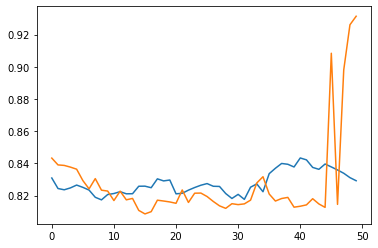

In [50]:
H3K4me3_50_top500 = RunDeconv('../../data/cutntag/processed/', './top500/', 'H3K4me3', '50um', 500)


In [51]:
H3K4me3_50_top500.model_all_names = ['NNLS', 'nnls_sp1', 'nnls_sp3', 'NNLS (+ spatial loss)', 'CARD', 'CARD (+ spatial loss)']

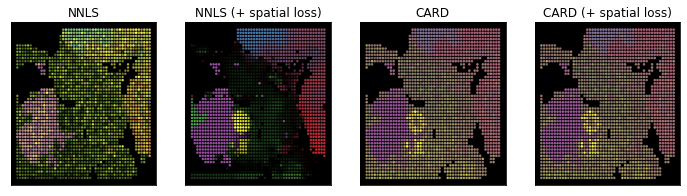

In [47]:
H3K4me3_50_top500.plot_model_and_ct(['NNLS', 'NNLS (+ spatial loss)', 'CARD', 'CARD (+ spatial loss)'], ct_group, ct_group_names, ct_colors)

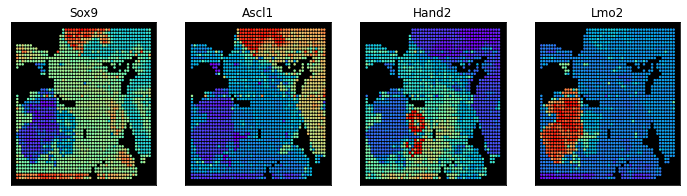

In [8]:
H3K4me3_50_top500.plot_ct_and_genes( ['Chondrocytes & osteoblasts','Neural Tube', 'Cardiac muscle lineages', 'Definitive erythroid lineage' ], ['Sox9', 'Ascl1', 'Hand2', 'Lmo2'])

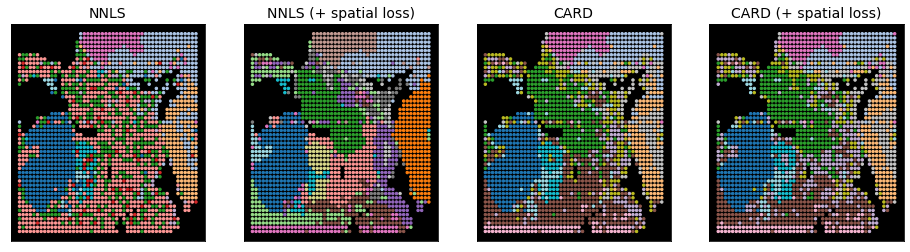

<Figure size 432x288 with 0 Axes>

In [52]:
H3K4me3_50_top500.plot_clustering(['NNLS', 'NNLS (+ spatial loss)', 'CARD', 'CARD (+ spatial loss)'])

Mir142           0.443890
Mir124a-2        0.372970
Mir196a-1        0.357097
Mir451a          0.334013
Mir344           0.319714
                   ...   
Foxh1            0.162805
Tmem88           0.162691
Usp29            0.162653
Psme2            0.162620
A930018P22Rik    0.162617
Length: 500, dtype: float64
Number of spots: 2159
Number of genes: 420
Number of celltypes: 37
Number of spots after QC: 2159
=== Time  1.26s. Total epoch 1076. Final loss: (total) 0.220. (spatial) 0.000.
=== Time  2.46s. Total epoch 1081. Final loss: (total) 0.220. (spatial) 0.000.
=== Time  2.46s. Total epoch 1076. Final loss: (total) 0.220. (spatial) 0.000.
=== Time  2.34s. Total epoch 1021. Final loss: (total) 0.221. (spatial) 0.001.


Registered S3 method overwritten by 'ggforce':
  method           from 
  scale_type.units units
Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy
Warning message:
replacing previous import ‘RcppML::nmf’ by ‘NMF::nmf’ when loading ‘CARD’ 
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine()    masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ ggplot2::Position() masks BiocGenerics::Position(), base::Position()


Deconvoluting sample H3K27ac.50um
[1] 2159    1
[1] 2159


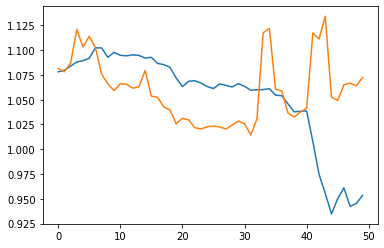

In [10]:
H3K27ac_50_top500 = RunDeconv('../../data/cutntag/processed/', './top500/', 'H3K27ac', '50um', 500)

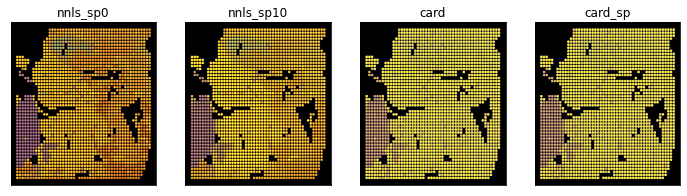

In [11]:
H3K27ac_50_top500.plot_model_and_ct(['nnls_sp0', 'nnls_sp10', 'card', 'card_sp'], ct_group, ct_group_names, ct_colors)

In [17]:
H3K27ac_50_top500.sp_score.index[H3K27ac_50_top500.sp_score.index.str.contains('Sox')]

Index(['Sox5', 'Sox15', 'Sox2', 'Sox1', 'Sox4', 'Sox2ot'], dtype='object')

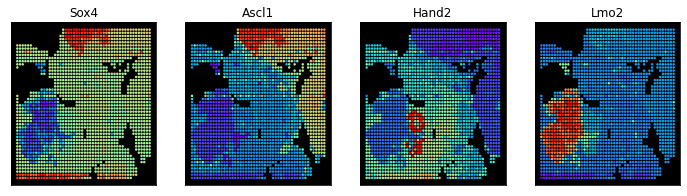

In [20]:
H3K4me3_50_top500.plot_ct_and_genes( ['Chondrocytes & osteoblasts','Neural Tube', 'Cardiac muscle lineages', 'Definitive erythroid lineage' ], ['Sox4', 'Ascl1', 'Hand2', 'Lmo2'])

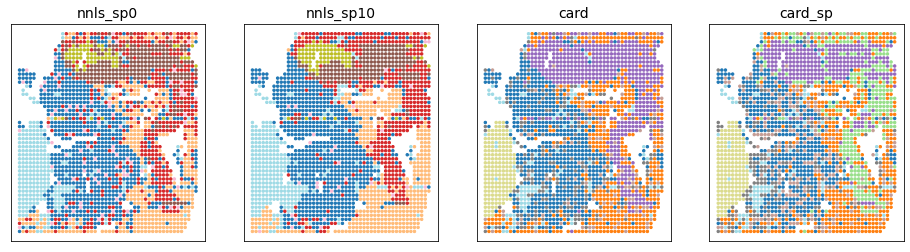

<Figure size 432x288 with 0 Axes>

In [13]:
H3K27ac_50_top500.plot_clustering(['nnls_sp0', 'nnls_sp10', 'card', 'card_sp'])

Mir9-3       0.444216
Sox2         0.325517
Mir124a-3    0.319590
Mir9-3hg     0.313368
Sox1         0.313224
               ...   
Cspg5        0.083107
Mir8114      0.083052
Slc2a7       0.083025
Hist3h2a     0.082975
Mira         0.082894
Length: 500, dtype: float64
Number of spots: 2100
Number of genes: 409
Number of celltypes: 37
Remove Row: [672]
Number of spots after QC: 2054
=== Time  7.28s. Total epoch 6206. Final loss: (total) 0.128. (spatial) 0.000.
=== Time  13.81s. Total epoch 6127. Final loss: (total) 0.128. (spatial) 0.000.
=== Time  13.39s. Total epoch 5978. Final loss: (total) 0.128. (spatial) 0.000.
=== Time  12.29s. Total epoch 5518. Final loss: (total) 0.129. (spatial) 0.001.


Registered S3 method overwritten by 'ggforce':
  method           from 
  scale_type.units units
Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy
Warning message:
replacing previous import ‘RcppML::nmf’ by ‘NMF::nmf’ when loading ‘CARD’ 
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine()    masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ ggplot2::Position() masks BiocGenerics::Position(), base::Position()


Deconvoluting sample H3K27ac.20um
[1] 2100    1
[1] 2054


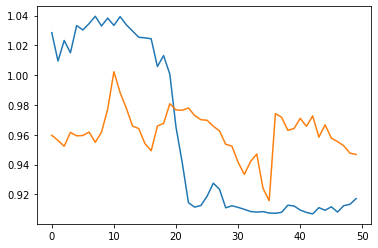

In [21]:
H3K27ac_20_top500 = RunDeconv('../../data/cutntag/processed/', './top500/', 'H3K27ac', '20um', 500)

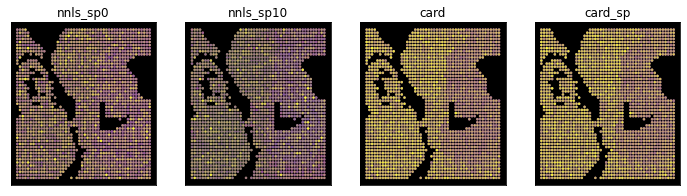

In [23]:
H3K27ac_20_top500.plot_model_and_ct(['nnls_sp0', 'nnls_sp10', 'card', 'card_sp'], ct_group, ct_group_names, ct_colors)

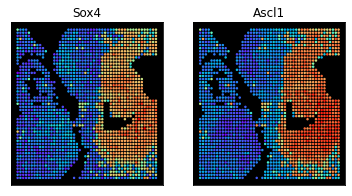

In [38]:
H3K27ac_20_top500.plot_ct_and_genes( ['Chondrocytes & osteoblasts','Neural Tube', ], ['Sox4', 'Ascl1', ])

In [ ]:
H3K27ac_20_top500.plot_clustering(['nnls_sp0', 'nnls_sp10', 'card', 'card_sp'])